# Track reconstruction validation

## In this notebook we are going to take the ROOT file produced by the validatetracksjob.fcl and make some plots!

Lets start by importing the relevant libraries

In [3]:
import pandas as pd
import uproot

Now, open the file we wish to collect the data from.

In [17]:
file = uproot.open('validationOutput.root')

print('Keys:', file.keys())
directory = file['ana']
tree = directory['tree']

Another way to access the tree would be tree = file['ana']['tree']

In [17]:
print('Tree name:', tree.name)
print('Tree title:', tree.title)
print('Number of entries:', tree.numentries)

Keys: [b'ana;1', b'MicroBoo znoise;1', b'MicroBoo unoise;1', b'MicroBoo vnoise;1', b'MicroBoo NoiseChan;1', b'Gaussian znoise;1', b'Gaussian unoise;1', b'Gaussian vnoise;1', b'Gaussian NoiseChan;1', b'Cohnoise;1', b'CohNoiseChan;1']
Tree name: b'tree'
Tree title: b'Analysis Output Tree'
Number of entries: 84


We can see what branches in this tree again using keys. We can use show for a more in depth look.

In [18]:
tree.keys()

[b'eventID',
 b'nPFParticles',
 b'nPrimaries',
 b'nDaughters',
 b'particleID',
 b'particlePDG',
 b'Lengths',
 b'ValidPoints',
 b'CosTheta',
 b'Phi',
 b'StartX',
 b'StartY',
 b'StartZ',
 b'EndX',
 b'EndY',
 b'EndZ']

In [19]:
tree.show()

eventID                    (no streamer)              asdtype('>f4')
nPFParticles               (no streamer)              asdtype('>f4')
nPrimaries                 (no streamer)              asdtype('>f4')
nDaughters                 TStreamerSTL               asjagged(asdtype('>i4'), 10)
particleID                 TStreamerSTL               asjagged(asdtype('>i4'), 10)
particlePDG                TStreamerSTL               asjagged(asdtype('>i4'), 10)
Lengths                    TStreamerSTL               asjagged(asdtype('>f4'), 10)
ValidPoints                TStreamerSTL               asjagged(asdtype('>f4'), 10)
CosTheta                   TStreamerSTL               asjagged(asdtype('>f4'), 10)
Phi                        TStreamerSTL               asjagged(asdtype('>f4'), 10)
StartX                     TStreamerSTL               asjagged(asdtype('>f4'), 10)
StartY                     TStreamerSTL               asjagged(asdtype('>f4'), 10)
StartZ                     TStreamerSTL       


We can convert all the information into a data frame.

In [24]:
df_reco = file['ana']['tree'].pandas.df('*', flatten=False)
df_reco

,eventID,nPFParticles,nPrimaries,nDaughters,particleID,particlePDG,Lengths,ValidPoints,CosTheta,Phi,StartX,StartY,StartZ,EndX,EndY,EndZ
entry,,,,,,,,,,,,,,,,
0,1.401298e-45,7.006492e-45,1.401298e-45,"[0, 0, 0, 0, 4]","[0, 1, 2, 3, 4]","[11, 13, 13, 11, 12]","[46.78872, 25.828798]","[176.0, 156.0]","[0.75512373, 0.8953485]","[-0.11911233, 2.7008083]","[-180.33942, -181.30333]","[80.0566, 81.86786]","[475.30435, 476.8262]","[-143.49002, -191.37592]","[65.63044, 86.610855]","[499.6893, 500.13013]"
1,2.802597e-45,4.203895e-45,1.401298e-45,"[1, 0, 1]","[0, 1, 2]","[13, 11, 14]",[16.13307],[99.0],[0.10920649],[1.2351865],[148.98648],[144.03868],[226.94334],[154.61002],[159.01628],[228.99007]
2,4.203895e-45,2.802597e-45,1.401298e-45,"[0, 1]","[0, 1]","[13, 14]",[6.8328185],[43.0],[0.86337644],[2.4097767],[67.46839],[-199.6801],[29.7986],[64.88822],[-197.3569],[35.683353]
3,5.605194e-45,4.203895e-45,1.401298e-45,"[0, 0, 2]","[0, 1, 2]","[13, 13, 14]","[107.225136, 9.842037]","[600.0, 64.0]","[0.5860917, 0.71606636]","[-2.2581947, 1.2965848]","[102.93546, 102.988945]","[84.88349, 84.823135]","[335.14297, 335.36957]","[48.41299, 104.838776]","[17.9011, 91.43788]","[398.35614, 342.41855]"
4,7.006492e-45,8.407791e-45,1.401298e-45,"[0, 0, 0, 1, 0, 4]","[0, 1, 2, 3, 4, 5]","[13, 13, 13, 13, 11, 14]","[411.15686, 54.198246, 40.64224, 25.56571]","[2653.0, 321.0, 182.0, 161.0]","[0.9640878, 0.8993289, 0.677297, 0.7172685]","[-2.2553425, 1.4909065, -0.023355538, 1.3095595]","[-46.70187, -42.10984, -45.92705, -46.693405]","[144.36487, 162.59413, 144.30197, 145.04634]","[100.877335, 120.11522, 101.953186, 101.828415]","[-96.188866, -36.28122, -14.813973, -41.973583]","[59.420082, 192.29088, 145.99072, 162.60585]","[499.89343, 164.8372, 127.684494, 119.78576]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,1.345247e-43,4.203895e-45,1.401298e-45,"[0, 0, 2]","[0, 1, 2]","[13, 13, 14]","[200.8229, 9.608759]","[726.0, 59.0]","[0.52362144, 0.8960504]","[0.054492593, -2.9277291]","[-100.35894, -100.67439]","[-113.77399, -113.94165]","[125.11095, 125.69161]","[70.14654, -104.81474]","[-118.29553, -114.84308]","[227.09537, 134.31557]"
80,1.359260e-43,2.802597e-45,1.401298e-45,"[0, 1]","[0, 1]","[13, 14]",[322.04852],[1867.0],[0.6826125],[1.9733975],[-79.505264],[-90.99844],[177.43282],[-155.54395],[100.1143],[423.3827]
81,1.373272e-43,4.203895e-45,1.401298e-45,"[0, 0, 2]","[0, 1, 2]","[13, 11, 14]",[16.04804],[66.0],[-0.37591648],[2.6452205],[100.33128],[-121.9194],[217.91476],[87.14599],[-114.72995],[212.26315]


<AxesSubplot:ylabel='Frequency'>

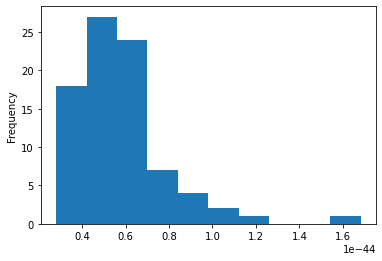

In [31]:
df_reco['nPFParticles'].plot.hist()

If we try plotting a +1D variable, i.e. a vector such Lenghts, in the same way as we called the plot of nPFParticles, we well hit an error. What we do want is one of the collection of PFParticles in each event, or at least the first PFParticle (for now).

In [37]:
df_reco['Lenghts'].plot.hist()

KeyError: 'Lenghts'